# Imports

In [1]:
import string
import sys
from collections import deque

import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

import kaggle

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Basic Data Analysis

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df.set_index("PassengerId", inplace=True)
train_df = shuffle(train_df)
train_df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
4864_01,Earth,False,G/784/P,55 Cancri e,24.0,False,0.0,0.0,0.0,734.0,21.0,NaN,False
1130_01,Mars,True,E/81/S,TRAPPIST-1e,23.0,False,NaN,0.0,0.0,0.0,0.0,Guaney Cako,False
7630_01,Earth,False,F/1585/P,55 Cancri e,48.0,False,0.0,172.0,115.0,1.0,645.0,Estina Hughriend,False
2687_01,Earth,False,F/556/P,TRAPPIST-1e,51.0,False,0.0,1347.0,0.0,43.0,0.0,Carry Kimons,True
6810_03,Mars,True,NaN,TRAPPIST-1e,16.0,False,NaN,0.0,0.0,0.0,0.0,Cings Knik,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7507_01,Earth,False,E/499/S,TRAPPIST-1e,19.0,False,0.0,789.0,0.0,0.0,0.0,Marlly Santin,False
5366_01,Europa,True,E/338/P,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Asellan Calved,True
1013_01,Earth,True,G/158/S,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,Weslie Farleyatton,False


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 4864_01 to 2954_01
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [5]:
train_df.isna().sum()/8693   # percentage of null

HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

In [6]:
train_df.nunique()

HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [7]:
train_df["RoomService"].value_counts()

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
731.0        1
1130.0       1
813.0        1
967.0        1
303.0        1
Name: RoomService, Length: 1273, dtype: int64

# Data Wrangling & EDA

In [8]:
# 1. Create new columns for missing data

train_df["HomePlanet_missing"] = train_df["HomePlanet"].isna()
train_df["CryoSleep_missing"] = train_df["CryoSleep"].isna()
train_df["Cabin_missing"] = train_df["Cabin"].isna()
train_df["Destination_missing"] = train_df["Destination"].isna()
train_df["Age_missing"] = train_df["Age"].isna()
train_df["VIP_missing"] = train_df["VIP"].isna()
train_df["RoomService_missing"] = train_df["RoomService"].isna()
train_df["FoodCourt_missing"] = train_df["FoodCourt"].isna()
train_df["ShoppingMall_missing"] = train_df["ShoppingMall"].isna()
train_df["Spa_missing"] = train_df["Spa"].isna()
train_df["VRDeck_missing"] = train_df["VRDeck"].isna()
train_df["Name_missing"] = train_df["Name"].isna()

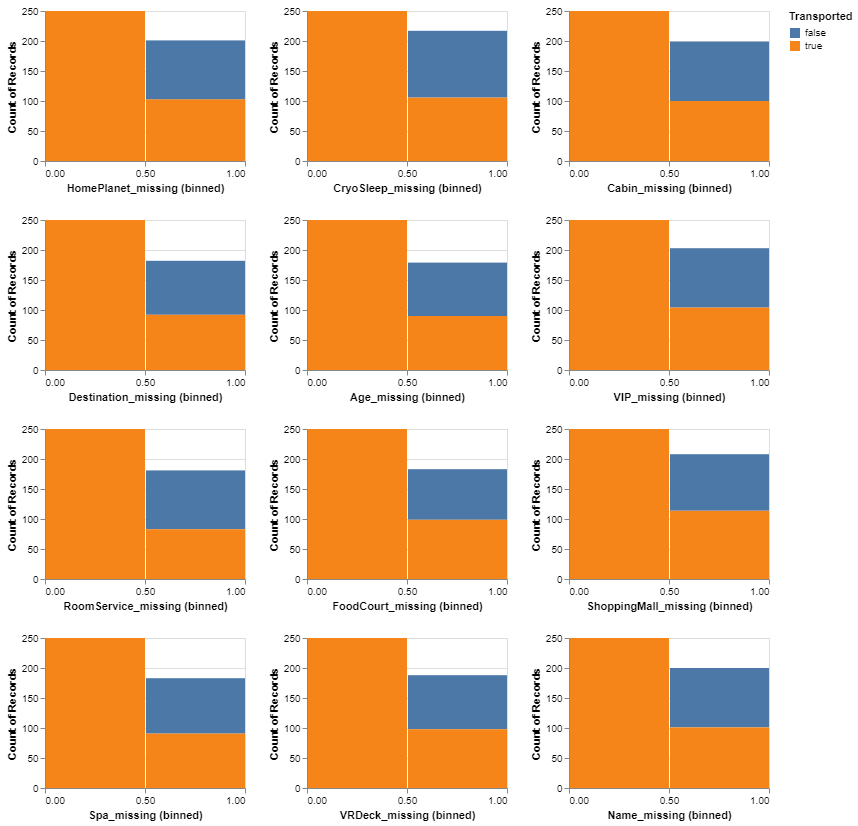

In [9]:
# 2. EDA on missing items

alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=2)),
    alt.Y('count()', scale=alt.Scale(domain=(0, 250))),
    fill='Transported'
).properties(
    width=200,
    height=150
).repeat(
    ["HomePlanet_missing", "CryoSleep_missing", "Cabin_missing",
     "Destination_missing", "Age_missing", "VIP_missing", "RoomService_missing",
     "FoodCourt_missing", "ShoppingMall_missing",
     "Spa_missing", "VRDeck_missing", "Name_missing"],
    columns=3
)

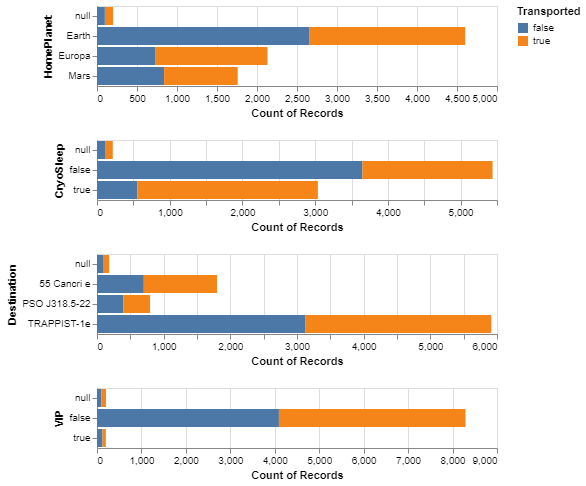

In [10]:
#3. EDA on Categorical variables

plot_homeplanet = alt.Chart(train_df).mark_bar().encode(
    y="HomePlanet",
    x='count()',
    fill='Transported'
)
plot_cryosleep = alt.Chart(train_df).mark_bar().encode(
    y="CryoSleep",
    x='count()',
    fill='Transported'
)
plot_destination = alt.Chart(train_df).mark_bar().encode(
    y="Destination",
    x='count()',
    fill='Transported'
)
plot_vip = alt.Chart(train_df).mark_bar().encode(
    y="VIP",
    x='count()',
    fill='Transported'
)

plot_homeplanet & plot_cryosleep & plot_destination & plot_vip

In [11]:
# 4. Divide Cabin in to sub 3 section

train_df[['Cabin_dec', 'Cabin_num', 'Cabin_side']] = train_df["Cabin"].str.split("/", expand=True)

In [12]:
train_df.nunique()

HomePlanet                 3
CryoSleep                  2
Cabin                   6560
Destination                3
Age                       80
VIP                        2
RoomService             1273
FoodCourt               1507
ShoppingMall            1115
Spa                     1327
VRDeck                  1306
Name                    8473
Transported                2
HomePlanet_missing         2
CryoSleep_missing          2
Cabin_missing              2
Destination_missing        2
Age_missing                2
VIP_missing                2
RoomService_missing        2
FoodCourt_missing          2
ShoppingMall_missing       2
Spa_missing                2
VRDeck_missing             2
Name_missing               2
Cabin_dec                  8
Cabin_num               1817
Cabin_side                 2
dtype: int64

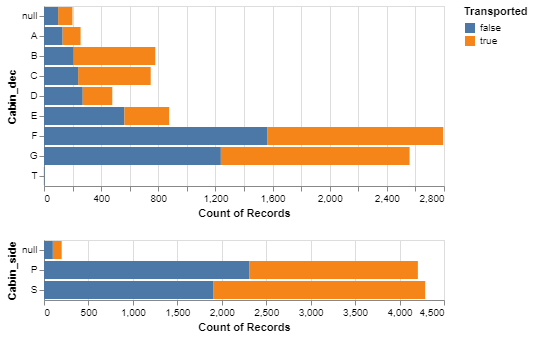

In [13]:
plot_cabin_dec = alt.Chart(train_df).mark_bar().encode(
    y="Cabin_dec",
    x='count()',
    fill='Transported'
)
plot_cabin_side = alt.Chart(train_df).mark_bar().encode(
    y="Cabin_side",
    x='count()',
    fill='Transported'
)

plot_cabin_dec & plot_cabin_side

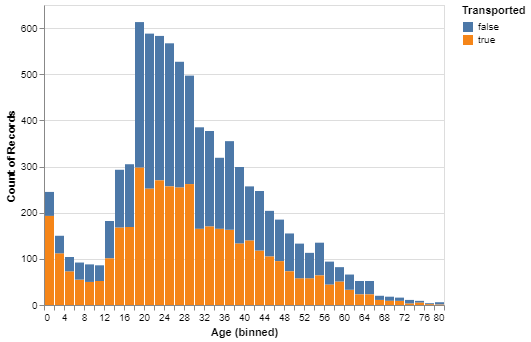

In [14]:
age_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('Age', bin=alt.Bin(maxbins=40)), 
    y='count()',
    fill='Transported')
age_histogram

In [15]:
# 5. Create Age groups

train_df['Age_bin'] = pd.cut(
    train_df['Age'], 
    bins=[0, 12, 18, 30, 50, 66, 90], 
    labels=['Children', 'Teenage', '20s', '30-40s', '50-60s', 'Elder']
)

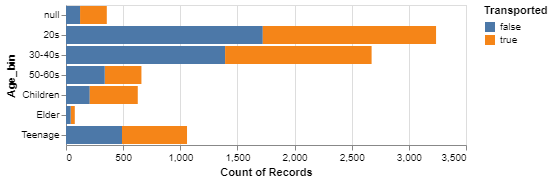

In [16]:
plot_age_bin = alt.Chart(train_df).mark_bar().encode(
    y="Age_bin",
    x='count()',
    fill='Transported'
)
plot_age_bin

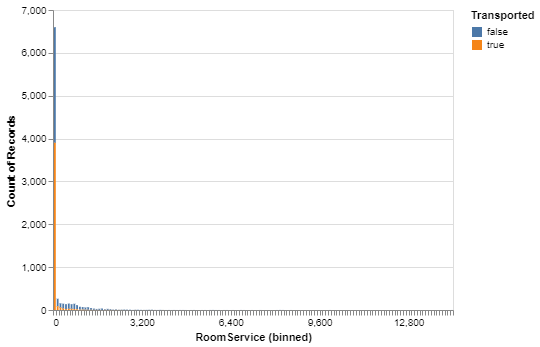

In [17]:
roomservice_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('RoomService', bin=alt.Bin(maxbins=200)), 
    y='count()',
    fill='Transported')
roomservice_histogram

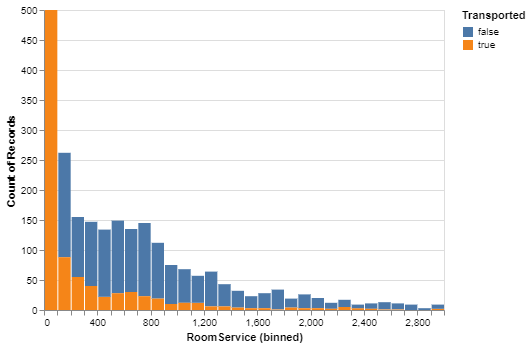

In [18]:
roomservice_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('RoomService', bin=alt.Bin(maxbins=200), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
roomservice_histogram2

In [19]:
# 6. Create RoomService groups

train_df.loc[train_df['RoomService'].isna(), 'RoomService'] = 0

train_df['RoomService_bin'] = pd.cut(
    train_df['RoomService'], 
    bins=[-100, 0, 100, 200, 400, 900, 2400, 15000], 
    labels=['RS$0', 'RS$0-100', 'RS$100-200', 'RS$200-400', 'RS$400-900', 'RS$900-2400', 'RS$2400-15000']
)


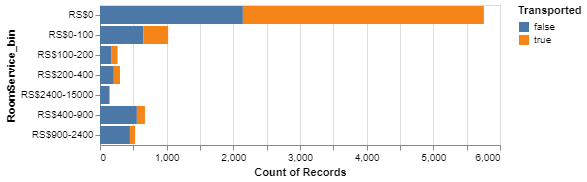

In [20]:
plot_roomservice_bin = alt.Chart(train_df).mark_bar().encode(
    y="RoomService_bin",
    x='count()',
    fill='Transported'
)
plot_roomservice_bin